# Prediksi Kecenderungan Depresi pada Mahasiswa

In [ ]:
!pip install --upgrade scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


In [ ]:
!pip install pyspark

In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession

from pyspark.sql.functions import col, when, create_map, lit
from pyspark.sql.functions import isnull, count, sum as _sum

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.appName("Student Depression Analysis").getOrCreate()
print(spark)
print(spark.version)

3.5.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/Student_Depression_Dataset.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

data.show(5)

+---+------+----+-------------+----------+-----------------+-------------+----+------------------+----------------+-----------------+--------------+-------+-------------------------------------+----------------+----------------+--------------------------------+----------+
| id|Gender| Age|         City|Profession|Academic Pressure|Work Pressure|CGPA|Study Satisfaction|Job Satisfaction|   Sleep Duration|Dietary Habits| Degree|Have you ever had suicidal thoughts ?|Work/Study Hours|Financial Stress|Family History of Mental Illness|Depression|
+---+------+----+-------------+----------+-----------------+-------------+----+------------------+----------------+-----------------+--------------+-------+-------------------------------------+----------------+----------------+--------------------------------+----------+
|  2|  Male|33.0|Visakhapatnam|   Student|              5.0|          0.0|8.97|               2.0|             0.0|        5-6 hours|       Healthy|B.Pharm|                         

# Pre-Processing Data

In [ ]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- Work Pressure: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Job Satisfaction: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Degree: string (nullable = true)
 |-- Have you ever had suicidal thoughts ?: string (nullable = true)
 |-- Work/Study Hours: double (nullable = true)
 |-- Financial Stress: double (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Depression: integer (nullable = true)



In [ ]:
data.head()

Row(id=2, Gender='Male', Age=33.0, City='Visakhapatnam', Profession='Student', Academic Pressure=5.0, Work Pressure=0.0, CGPA=8.97, Study Satisfaction=2.0, Job Satisfaction=0.0, Sleep Duration='5-6 hours', Dietary Habits='Healthy', Degree='B.Pharm', Have you ever had suicidal thoughts ?='Yes', Work/Study Hours=3.0, Financial Stress=1.0, Family History of Mental Illness='No', Depression=1)

In [ ]:
data = data.drop("id", "City", "Profession", "Work Pressure", "Degree", "Have you ever had suicidal thoughts ?")
data.show()

+------+----+-----------------+----+------------------+----------------+-----------------+--------------+----------------+----------------+--------------------------------+----------+
|Gender| Age|Academic Pressure|CGPA|Study Satisfaction|Job Satisfaction|   Sleep Duration|Dietary Habits|Work/Study Hours|Financial Stress|Family History of Mental Illness|Depression|
+------+----+-----------------+----+------------------+----------------+-----------------+--------------+----------------+----------------+--------------------------------+----------+
|  Male|33.0|              5.0|8.97|               2.0|             0.0|        5-6 hours|       Healthy|             3.0|             1.0|                              No|         1|
|Female|24.0|              2.0| 5.9|               5.0|             0.0|        5-6 hours|      Moderate|             3.0|             2.0|                             Yes|         0|
|  Male|31.0|              3.0|7.03|               5.0|             0.0|Less tha

In [ ]:
data.columns

['Gender',
 'Age',
 'Academic Pressure',
 'CGPA',
 'Study Satisfaction',
 'Job Satisfaction',
 'Sleep Duration',
 'Dietary Habits',
 'Work/Study Hours',
 'Financial Stress',
 'Family History of Mental Illness',
 'Depression']

In [ ]:
data = data.withColumnRenamed("Academic Pressure", "Academic_Pressure") \
           .withColumnRenamed("Work Pressure", "Work_Pressure") \
           .withColumnRenamed("Study Satisfaction", "Study_Satisfaction") \
           .withColumnRenamed("Job Satisfaction", "Job_Satisfaction") \
           .withColumnRenamed("Sleep Duration", "Sleep_Duration") \
           .withColumnRenamed("Dietary Habits", "Dietary_Habits") \
           .withColumnRenamed("Work/Study Hours", "Work_Study_Hours") \
           .withColumnRenamed("Financial Stress", "Financial_Stress") \
           .withColumnRenamed("Family History of Mental Illness", "Family_History")

In [ ]:
# menampilkan data kosong
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+------+---+-----------------+----+------------------+----------------+--------------+--------------+----------------+----------------+--------------+----------+
|Gender|Age|Academic_Pressure|CGPA|Study_Satisfaction|Job_Satisfaction|Sleep_Duration|Dietary_Habits|Work_Study_Hours|Financial_Stress|Family_History|Depression|
+------+---+-----------------+----+------------------+----------------+--------------+--------------+----------------+----------------+--------------+----------+
|     0|  0|                0|   0|                 0|               0|             0|             0|               0|               3|             0|         0|
+------+---+-----------------+----+------------------+----------------+--------------+--------------+----------------+----------------+--------------+----------+



In [ ]:
data = data.dropna()

data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+------+---+-----------------+----+------------------+----------------+--------------+--------------+----------------+----------------+--------------+----------+
|Gender|Age|Academic_Pressure|CGPA|Study_Satisfaction|Job_Satisfaction|Sleep_Duration|Dietary_Habits|Work_Study_Hours|Financial_Stress|Family_History|Depression|
+------+---+-----------------+----+------------------+----------------+--------------+--------------+----------------+----------------+--------------+----------+
|     0|  0|                0|   0|                 0|               0|             0|             0|               0|               0|             0|         0|
+------+---+-----------------+----+------------------+----------------+--------------+--------------+----------------+----------------+--------------+----------+



In [ ]:
sleep_mapping_expr = when(col("Sleep_Duration") == "Less than 5 hours", 4.5)

data = data.withColumn("Sleep_Duration",
    when(col("Sleep_Duration") == "Less than 5 hours", 4.0)
    .when(col("Sleep_Duration") == "5-6 hours", 5.6)
    .when(col("Sleep_Duration") == "7-8 hours", 7.8)
    .when(col("Sleep_Duration") == "More than 8 hours", 9.0)
    .otherwise(None)
)

In [ ]:
data.printSchema()
data.show(5)

root
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Academic_Pressure: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Study_Satisfaction: double (nullable = true)
 |-- Job_Satisfaction: double (nullable = true)
 |-- Sleep_Duration: double (nullable = true)
 |-- Dietary_Habits: string (nullable = true)
 |-- Work_Study_Hours: double (nullable = true)
 |-- Financial_Stress: double (nullable = true)
 |-- Family_History: string (nullable = true)
 |-- Depression: integer (nullable = true)

+------+----+-----------------+----+------------------+----------------+--------------+--------------+----------------+----------------+--------------+----------+
|Gender| Age|Academic_Pressure|CGPA|Study_Satisfaction|Job_Satisfaction|Sleep_Duration|Dietary_Habits|Work_Study_Hours|Financial_Stress|Family_History|Depression|
+------+----+-----------------+----+------------------+----------------+--------------+--------------+----------------+----------------

### Encoding Data dan Normalisasi Data(scalling)

In [ ]:
# Membuat StringIndexer
indexers = [
    StringIndexer(inputCol="Gender", outputCol="Gender_Index"),
    StringIndexer(inputCol="Dietary_Habits", outputCol="Dietary_Habits_Index"),
    StringIndexer(inputCol="Family_History", outputCol="Family_History_Index")
]

# Fit each StringIndexer individually and transform the data
for indexer in indexers:
    data = indexer.fit(data).transform(data)

In [ ]:
# Impute missing values with the mean for numerical columns
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["CGPA", "Academic_Pressure", "Sleep_Duration"],
    outputCols=["CGPA", "Academic_Pressure", "Sleep_Duration"]
)
imputer.setStrategy("mean") # Use mean imputation
data = imputer.fit(data).transform(data)

# Combine numerical columns into a vector
numerical_cols = ["CGPA", "Academic_Pressure", "Sleep_Duration"]
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="Numerical_Vector")
data = assembler.transform(data)


# Apply Standard Scaling
scaler = StandardScaler(inputCol="Numerical_Vector", outputCol="Scaled_Numerical_Vector", withMean=True, withStd=True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Verify transformed data
data.select("Gender_Index", "Family_History_Index", "Dietary_Habits_Index", "Scaled_Numerical_Vector").show(5)

+------------+--------------------+--------------------+-----------------------+
|Gender_Index|Family_History_Index|Dietary_Habits_Index|Scaled_Numerical_Vector|
+------------+--------------------+--------------------+-----------------------+
|         0.0|                 0.0|                 2.0|   [0.89333813270901...|
|         1.0|                 1.0|                 1.0|   [-1.1940911804281...|
|         0.0|                 1.0|                 2.0|   [-0.4257540065372...|
|         1.0|                 1.0|                 1.0|   [-1.4048739449468...|
|         1.0|                 0.0|                 1.0|   [0.32218483530340...|
+------------+--------------------+--------------------+-----------------------+
only showing top 5 rows



In [ ]:
data = data.drop("Gender", "Dietary_Habits", "Family_History")

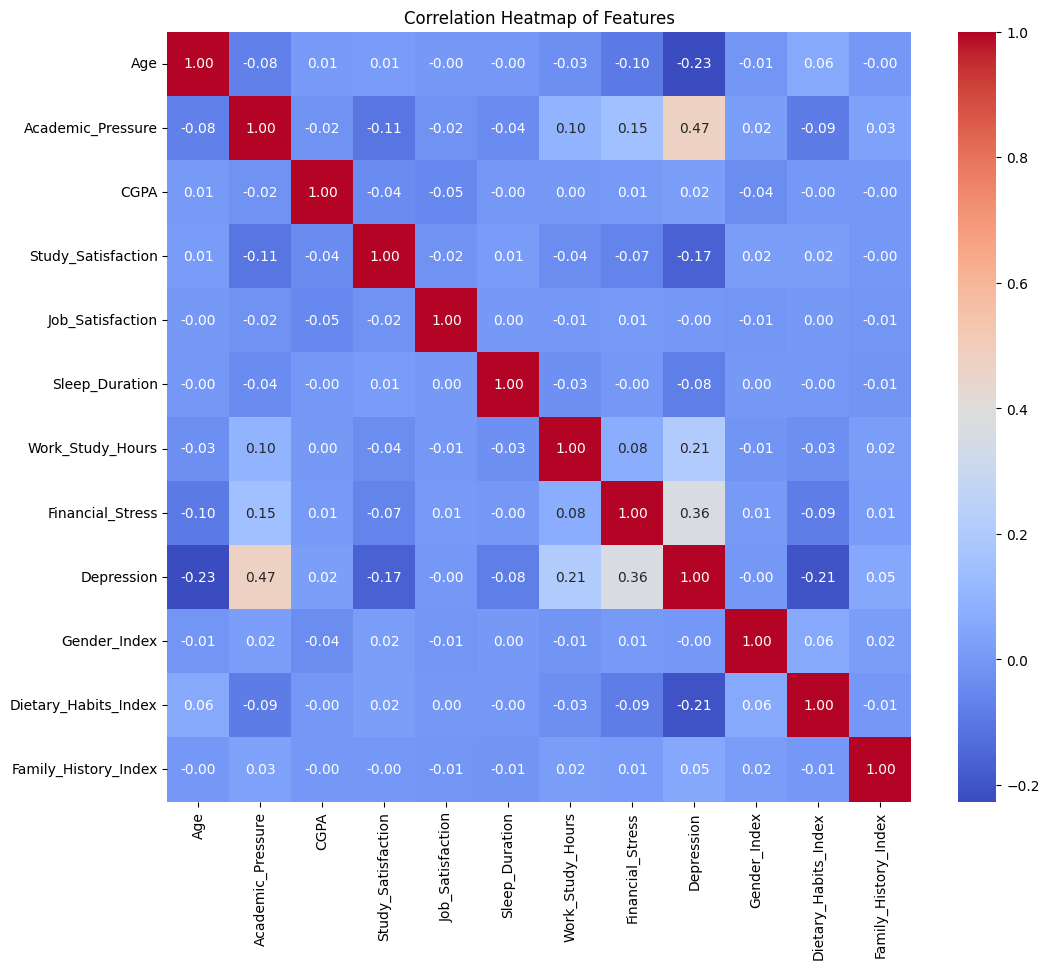

In [ ]:
# Convert cleaned Spark DataFrame to Pandas DataFrame for correlation calculation
# Exclude vector columns from casting
pandas_data = data.select([
    col(c).cast("double") if c not in ["Numerical_Vector", "Scaled_Numerical_Vector"] else col(c)
    for c in data.columns
]).toPandas()

# Calculate correlation matrix
# Select only numerical columns for correlation calculation
numerical_cols_pandas = [c for c in pandas_data.columns if c not in ["Numerical_Vector", "Scaled_Numerical_Vector"]]
correlation_matrix = pandas_data[numerical_cols_pandas].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features")
plt.show()

# Exploratory Data Analysis (EDA)

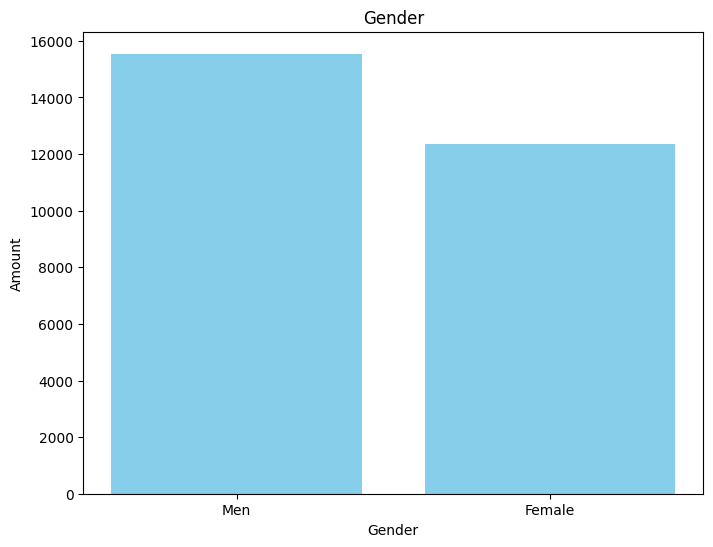

In [ ]:
# Extract Gender_Index data and calculate counts
gender_counts = data.groupBy("Gender_Index").count().toPandas()

# Create the bar chart using the extracted data
plt.figure(figsize=(8, 6))
plt.bar(gender_counts["Gender_Index"], gender_counts["count"], color='skyblue')
plt.xlabel("Gender")
plt.ylabel("Amount")
plt.title("Gender")
# Assuming Gender_Index 0 represents Men and 1 represents Women
plt.xticks(gender_counts["Gender_Index"], ["Men", "Female"])  # Set ticks and labels
plt.show()

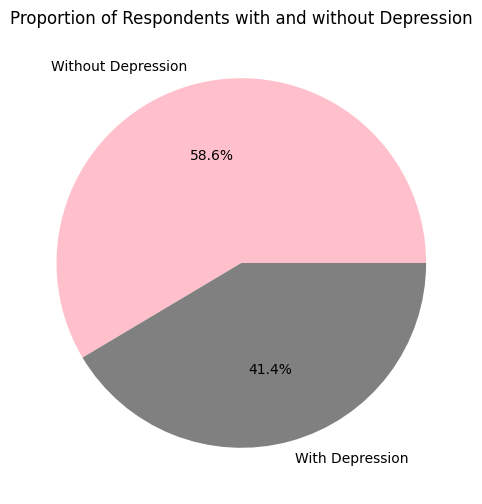

In [ ]:
# Pie Chart untuk distribusi depresi
depression_counts = pandas_data["Depression"].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(depression_counts, labels=["Without Depression", "With Depression"], autopct="%1.1f%%", colors=["pink", "grey"])
plt.title("Proportion of Respondents with and without Depression")
plt.show()

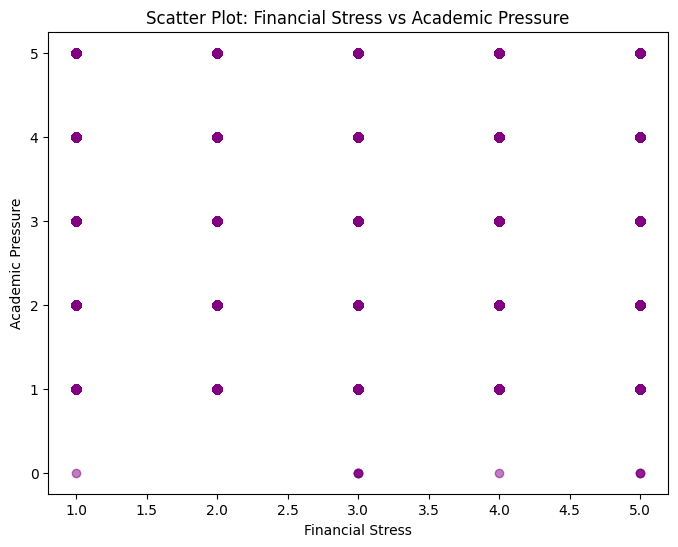

In [ ]:
# Scatter Plot: Financial Stress vs Academic Pressure
plt.figure(figsize=(8, 6))
plt.scatter(pandas_data["Financial_Stress"], pandas_data["Academic_Pressure"], alpha=0.5, color="purple")
plt.xlabel("Financial Stress")
plt.ylabel("Academic Pressure")
plt.title("Scatter Plot: Financial Stress vs Academic Pressure")
plt.show()

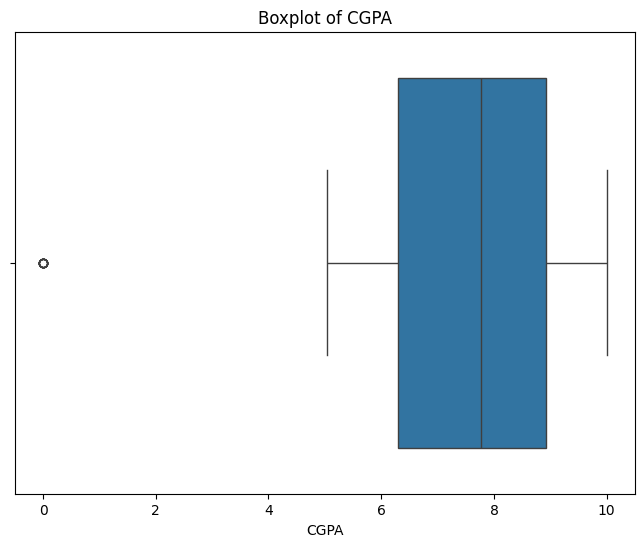

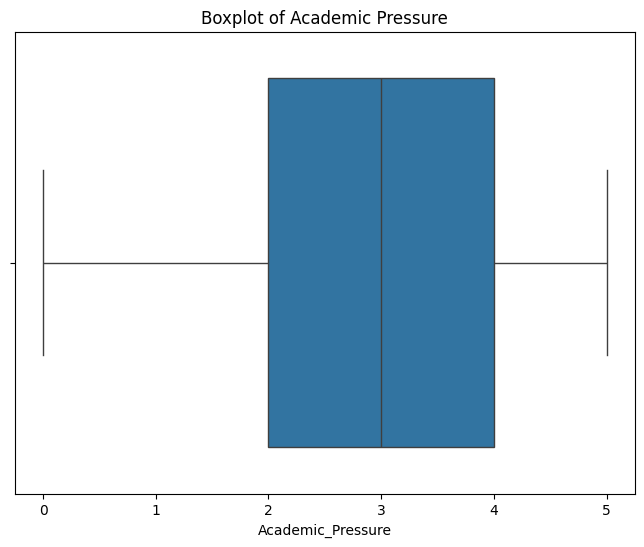

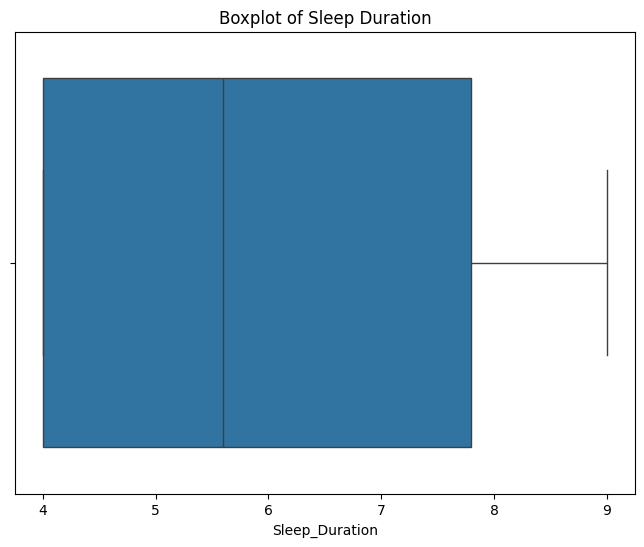

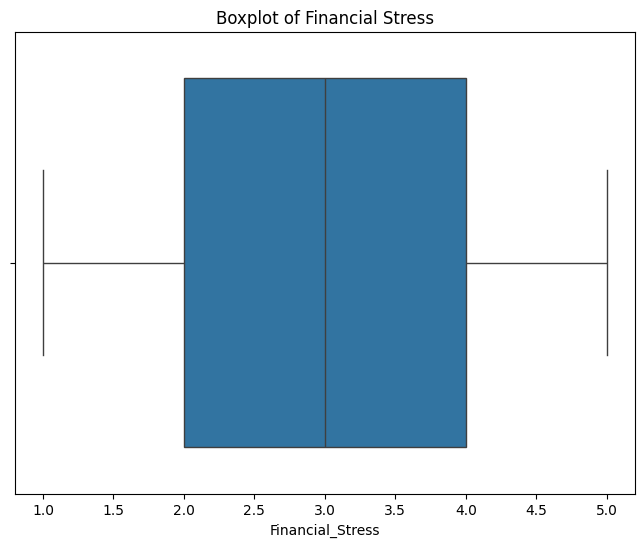

In [ ]:
# Boxplot for 'CGPA'
plt.figure(figsize=(8, 6))
sns.boxplot(x=pandas_data["CGPA"])
plt.title("Boxplot of CGPA")
plt.show()

# Boxplot for 'Academic_Pressure'
plt.figure(figsize=(8, 6))
sns.boxplot(x=pandas_data["Academic_Pressure"])
plt.title("Boxplot of Academic Pressure")
plt.show()

# Boxplot for 'Sleep_Duration'
plt.figure(figsize=(8, 6))
sns.boxplot(x=pandas_data["Sleep_Duration"])
plt.title("Boxplot of Sleep Duration")
plt.show()

# Boxplot for 'Financial_Stress'
plt.figure(figsize=(8, 6))
sns.boxplot(x=pandas_data["Financial_Stress"])
plt.title("Boxplot of Financial Stress")
plt.show()

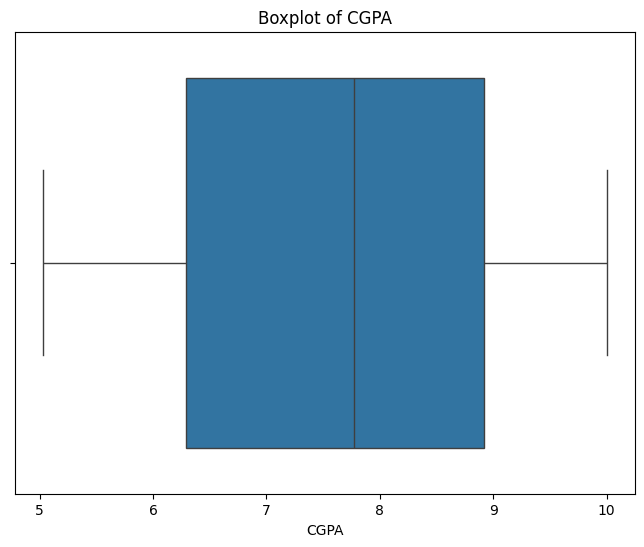

In [ ]:
# Calculate Q1, Q3, and IQR for CGPA
Q1_cgpa = pandas_data["CGPA"].quantile(0.25)
Q3_cgpa = pandas_data["CGPA"].quantile(0.75)
IQR_cgpa = Q3_cgpa - Q1_cgpa

# Define bounds for outliers
lower_bound_cgpa = Q1_cgpa - 1.5 * IQR_cgpa
upper_bound_cgpa = Q3_cgpa + 1.5 * IQR_cgpa

# Filter out outliers
pandas_data = pandas_data[
    (pandas_data["CGPA"] >= lower_bound_cgpa) & (pandas_data["CGPA"] <= upper_bound_cgpa)
]

# Boxplot for 'CGPA'
plt.figure(figsize=(8, 6))
sns.boxplot(x=pandas_data["CGPA"])
plt.title("Boxplot of CGPA")
plt.show()

##Balancing Data

In [ ]:
from imblearn.over_sampling import SMOTE

# Pisahkan fitur dan target
# Exclude the 'Scaled_Numerical_Vector' column from features
X = pandas_data.drop(columns=["Depression", "Scaled_Numerical_Vector", "Numerical_Vector"])  # Exclude vector columns
y = pandas_data["Depression"]

# Terapkan SMOTE untuk over-sampling
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Gabungkan kembali menjadi DataFrame
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df["Depression"] = y_resampled

# Ubah kembali ke DataFrame PySpark jika diperlukan
balanced_data = spark.createDataFrame(resampled_df)

In [ ]:
# Cek distribusi target 'Depression' sebelum dan sesudah balancing
print("Jumlah kelas sebelum balancing:")
# Use value_counts on the Pandas DataFrame to get the distribution
print(pandas_data["Depression"].value_counts())

print("Jumlah kelas setelah balancing:")
balanced_data.groupBy("Depression").count().show()

Jumlah kelas sebelum balancing:
Depression
1.0    16331
0.0    11558
Name: count, dtype: int64
Jumlah kelas setelah balancing:
+----------+-----+
|Depression|count|
+----------+-----+
|       0.0|16331|
|       1.0|16331|
+----------+-----+



In [ ]:
train, test = balanced_data.randomSplit([0.8, 0.2], seed=42)

train_count = train.count()
test_count = test.count()

print(f"Training data count: {train_count}")
print(f"Testing data count: {test_count}")

Training data count: 26290
Testing data count: 6372


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

features = balanced_data.columns
features.remove("Depression")
assembler = VectorAssembler(inputCols=features, outputCol="features")
balanced_data = assembler.transform(balanced_data)

train, test = balanced_data.randomSplit([0.8, 0.2], seed=42)

# Random Forest
rf = RandomForestClassifier(labelCol="Depression", featuresCol="features")
# Gradient Boost Tree
gbt = GBTClassifier(labelCol="Depression", featuresCol="features")
# Support Vector Machine
svm = LinearSVC(labelCol="Depression", featuresCol="features")
# Logistic Regression
lr = LogisticRegression(labelCol="Depression", featuresCol="features")

models = {"Random Forest": rf, "Gradient Boost Tree": gbt, "SVM": svm, "Logistic Regression": lr}
results = {}

for name, model in models.items():
    fitted_model = model.fit(train)
    predictions = fitted_model.transform(test)

    # Evaluate metrics
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Depression", metricName="accuracy")
    accuracy = evaluator_accuracy.evaluate(predictions)

    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Depression", metricName="f1")
    f1_score = evaluator_f1.evaluate(predictions)

    evaluator_precision = MulticlassClassificationEvaluator(labelCol="Depression", metricName="weightedPrecision")
    precision = evaluator_precision.evaluate(predictions)

    evaluator_recall = MulticlassClassificationEvaluator(labelCol="Depression", metricName="weightedRecall")
    recall = evaluator_recall.evaluate(predictions)

    evaluator_auc = BinaryClassificationEvaluator(labelCol="Depression", metricName="areaUnderROC")
    auc = evaluator_auc.evaluate(predictions)

    results[name] = {
        "Accuracy": accuracy,
        "F1 Score": f1_score,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc
    }

# Display results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

Random Forest:
  Accuracy: 0.7984934086629002
  F1 Score: 0.7984934086629002
  Precision: 0.798544385004107
  Recall: 0.7984934086629002
  AUC: 0.8701361894538391
Gradient Boost Tree:
  Accuracy: 0.8188951663527935
  F1 Score: 0.8188920440239291
  Precision: 0.8189897745063357
  Recall: 0.8188951663527935
  AUC: 0.8976317087857355
SVM:
  Accuracy: 0.7984934086629002
  F1 Score: 0.7984945203795926
  Precision: 0.7984981493698871
  Recall: 0.7984934086629002
  AUC: 0.8767767011563818
Logistic Regression:
  Accuracy: 0.7991211550533585
  F1 Score: 0.7991217883447593
  Precision: 0.799123051453039
  Recall: 0.7991211550533583
  AUC: 0.876840689589401


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Split data into training and testing sets
train, test = balanced_data.randomSplit([0.8, 0.2], seed=42)

# Evaluator for AUC
evaluator = BinaryClassificationEvaluator(labelCol="Depression", metricName="areaUnderROC")

# === Gradient Boosted Tree (GBT) ===
gbt = GBTClassifier(labelCol="Depression", featuresCol="features")
gbt_param_grid = (ParamGridBuilder()
                  .addGrid(gbt.maxDepth, [3, 5, 7])
                  .addGrid(gbt.maxIter, [50, 70])
                  .addGrid(gbt.stepSize, [0.1, 0.2, 0.3])
                  .build())

gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_param_grid, evaluator=evaluator, numFolds=3)
gbt_model = gbt_cv.fit(train)
gbt_best_model = gbt_model.bestModel

gbt_predictions = gbt_best_model.transform(test)
gbt_accuracy = MulticlassClassificationEvaluator(labelCol="Depression", metricName="accuracy").evaluate(gbt_predictions)
gbt_f1 = MulticlassClassificationEvaluator(labelCol="Depression", metricName="f1").evaluate(gbt_predictions)
gbt_precision = MulticlassClassificationEvaluator(labelCol="Depression", metricName="weightedPrecision").evaluate(gbt_predictions)
gbt_recall = MulticlassClassificationEvaluator(labelCol="Depression", metricName="weightedRecall").evaluate(gbt_predictions)
gbt_auc = evaluator.evaluate(gbt_predictions)

# === Support Vector Machine (SVM) ===
svm = LinearSVC(labelCol="Depression", featuresCol="features")
svm_param_grid = (ParamGridBuilder()
                  .addGrid(svm.regParam, [0.1, 0.5, 1.0])
                  .addGrid(svm.maxIter, [50, 70])
                  .build())

# Cross Validation
evaluator = BinaryClassificationEvaluator(labelCol="Depression", metricName="areaUnderROC")
svm_cv = CrossValidator(estimator=svm, estimatorParamMaps=svm_param_grid, evaluator=evaluator, numFolds=3)

# Train Model
svm_model = svm_cv.fit(train)
svm_best_model = svm_model.bestModel

# Predictions
svm_predictions = svm_best_model.transform(test)

# Evaluation Metrics
svm_accuracy = MulticlassClassificationEvaluator(labelCol="Depression", metricName="accuracy").evaluate(svm_predictions)
svm_f1 = MulticlassClassificationEvaluator(labelCol="Depression", metricName="f1").evaluate(svm_predictions)
svm_precision = MulticlassClassificationEvaluator(labelCol="Depression", metricName="weightedPrecision").evaluate(svm_predictions)
svm_recall = MulticlassClassificationEvaluator(labelCol="Depression", metricName="weightedRecall").evaluate(svm_predictions)
svm_auc = evaluator.evaluate(svm_predictions)

# Print results
print("=== Best Parameters and Evaluation ===")
print(f"GBT Best Parameters: maxDepth={gbt_best_model.getMaxDepth()}, maxIter={gbt_best_model.getMaxIter()}, stepSize={gbt_best_model.getStepSize()}")
print(f"GBT - Accuracy: {gbt_accuracy}, F1 Score: {gbt_f1}, Precision: {gbt_precision}, Recall: {gbt_recall}, AUC: {gbt_auc}")
print()
print(f"SVM Best Parameters: regParam={svm_best_model.getRegParam()}, maxIter={svm_best_model.getMaxIter()}")
print(f"SVM - Accuracy: {svm_accuracy}, F1 Score: {svm_f1}, Precision: {svm_precision}, Recall: {svm_recall}, AUC: {svm_auc}")


=== Best Parameters and Evaluation ===
GBT Best Parameters: maxDepth=3, maxIter=70, stepSize=0.3
GBT - Accuracy: 0.8278405524168236, F1 Score: 0.8278068092617001, Precision: 0.8282578980069992, Recall: 0.8278405524168235, AUC: 0.9086502805047992

SVM Best Parameters: regParam=0.1, maxIter=70
SVM - Accuracy: 0.7997489014438167, F1 Score: 0.7997504205082169, Precision: 0.7997710063780498, Recall: 0.7997489014438167, AUC: 0.8767020726144084


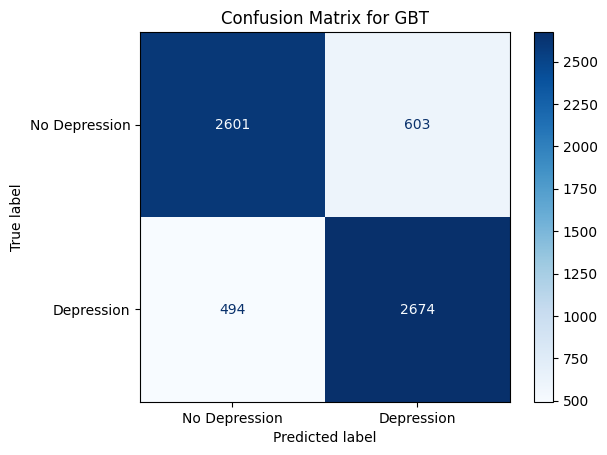

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions and labels to Pandas DataFrame
gbt_predictions_df = gbt_predictions.select("Depression", "prediction").toPandas()

# Confusion Matrix
cm = confusion_matrix(gbt_predictions_df["Depression"], gbt_predictions_df["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Depression", "Depression"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix for GBT")
plt.show()
